<a href="https://colab.research.google.com/github/brenttoast/C964_Project/blob/main/C964_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ipywidgets import interact, widgets, Dropdown
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Set dataset folder and radio data filenames

In [198]:
data_folder = 'https://raw.githubusercontent.com/brenttoast/C964_Project/main/data/'
file_type = '.json'
radio_data = [
    'noc_bmd',
    'noc_bv',
    'noc_col',
    'noc_gwt',
    'noc_he',
    'noc_hg',
    'noc_hw',
    'noc_sar',
    'noc_tt',
    'noc_tur'
]

In [199]:
def json_download(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

train_temperature = json_download(f'{data_folder}temps{file_type}')
train_temperature = pd.DataFrame(train_temperature).rename(columns={"dt": "time"})
train_temperature = train_temperature[['time', 'main']]
train_temperature['temp'] = train_temperature['main'].apply(lambda x: x['temp'])
train_temperature = train_temperature[['time', 'temp']]
train_temperature['time'] = pd.to_datetime(train_temperature['time'], unit='s')
train_temperature['time'] = train_temperature['time'].dt.tz_localize('Etc/GMT')
train_temperature['time'] = train_temperature['time'] + pd.DateOffset(hours=1, minutes=30)
radio_stats_all = []

for json_file in radio_data:
    radio_info = json_download(f'{data_folder}{json_file}{file_type}')
    
    azimuth = radio_info['meta']['azimuth']
    height = radio_info['meta']['height']
    radio_info = pd.DataFrame(radio_info["data"]).rename(columns={"sensor": "rsl"})
    radio_info['link_name'] = f'{json_file}'
    radio_info['time'] = pd.to_datetime(radio_info['time'], format='%Y-%m-%d %H:%M:%S')
    radio_info['time'] = radio_info['time'].dt.tz_localize('US/Pacific')
    radio_info = pd.merge(radio_info, train_temperature, on='time')
    radio_info['rsl_delta'] = abs(radio_info['rsl'] - stats.mode(radio_info['rsl'])[0])
    radio_info['azimuth'] = azimuth
    radio_info['azimuth_sin'] = np.sin(np.radians(azimuth))
    radio_info['azimuth_cos'] = np.cos(np.radians(azimuth))
    radio_info['height'] = height
    radio_stats_all.extend(radio_info.to_dict(orient='records'))

df = pd.DataFrame(radio_stats_all)

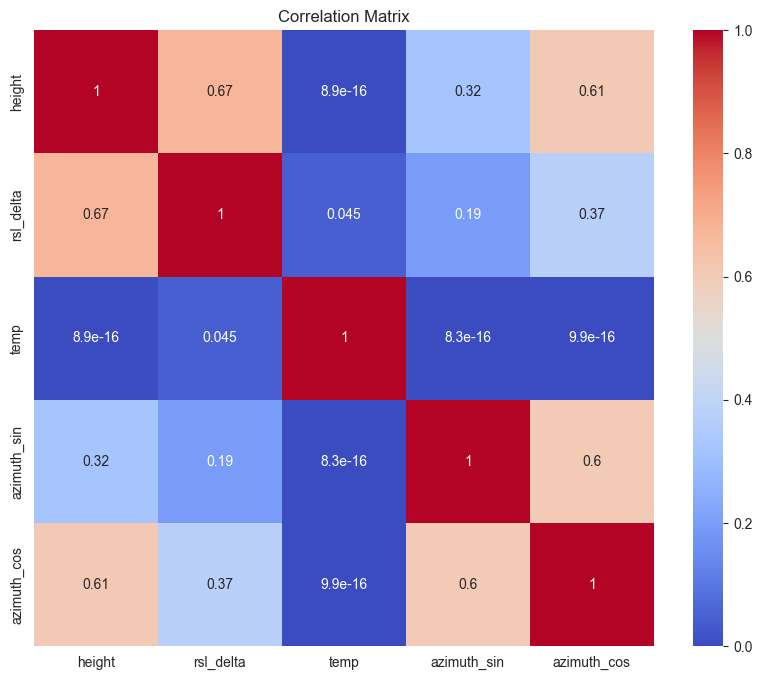

In [200]:
corr_matrix = df[['height', 'rsl_delta', 'temp', 'azimuth_sin', 'azimuth_cos']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [201]:
X = df[['temp', 'height', 'azimuth_sin', 'azimuth_cos']]
y = (df['rsl_delta'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)

model = RandomForestRegressor(n_estimators=103, random_state=33)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MAE: 0.38163488010699537
MSE: 0.3395227436227223
R^2: 0.8170680838773952


In [202]:
link_names = df['link_name'].unique()

dropdown = Dropdown(
    options=link_names,
    description='Select Link: ',
)

def plot_temp_rsl_change(link_name='noc_bv'):
    
    link_data = df[df['link_name'] == link_name]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.plot(link_data['time'], link_data['temp'], alpha = 0.5, label='Temperature', color='red')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature C')
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx()
    ax2.plot(link_data['time'], link_data['rsl_delta'], alpha=0.5, label='RSL', color='blue')
    ax2.set_ylabel('RSL')
    ax2.tick_params(axis='y')
    

    plt.show()
    
interact(plot_temp_rsl_change, link_name=dropdown)

interactive(children=(Dropdown(description='Select Link: ', options=('noc_bmd', 'noc_bv', 'noc_col', 'noc_gwt'…

<function __main__.plot_temp_rsl_change(link_name='noc_bv')>

In [203]:
def plot_rsl_change(input_height=35, input_azimuth=0):
    temperatures = np.arange(10, 35, 0.1)
    predicted_rsl = []

    for temp in temperatures:
        inputs = pd.DataFrame({
            'temp': [temp], 'height': [input_height],
            'azimuth_sin': [np.sin(np.radians(input_azimuth))],
            'azimuth_cos': [np.cos(np.radians(input_azimuth))]
        })
        predicted_rsl.append(model.predict(inputs)[0])

    smooth_plot = pd.DataFrame({'rsl_change': predicted_rsl})
    smooth_plot['rsl_change_smooth'] = smooth_plot['rsl_change'].rolling(window=50, center=True).mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(temperatures, predicted_rsl, alpha = 0.5)
    plt.plot(temperatures, smooth_plot['rsl_change_smooth'], linestyle='--')
    
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Potential RSL Change (dBm)')
    plt.yticks(np.arange(0, 20, 0.5))
    plt.ylim(0, 5)
    plt.title(f'RSL Change vs. Temperature (Height: {input_height}m, Azimuth: {input_azimuth}°)')
    plt.grid(True)
    plt.show()


interact(plot_rsl_change,
         input_height=widgets.IntSlider(min=30, max=50, step=1, value=35, description='Height (m)'),
         input_azimuth=widgets.IntSlider(min=0, max=360, step=1, value=180, description='Azimuth (°)')
         )

interactive(children=(IntSlider(value=35, description='Height (m)', max=50, min=30), IntSlider(value=180, desc…

<function __main__.plot_rsl_change(input_height=35, input_azimuth=0)>